# Supervised Learning for 4x4 Sudoku

Using Pretrained: H=3, L=4, L_layers=2, hidden=128

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Architecture: H=2, L=4, L_layers=3
HIDDEN_SIZE = 128
NUM_HEADS = 4
L_LAYERS = 3
L_CYCLES = 4
H_CYCLES = 2

# Training config (shared by all models)
NUM_EPOCHS = 100
BATCH_SIZE = 32
BATCHES_PER_EPOCH = 100

print(f"\nArchitecture: H={H_CYCLES}, L={L_CYCLES}, L_layers={L_LAYERS}, hidden={HIDDEN_SIZE}")
print(f"Training: {NUM_EPOCHS} epochs × {BATCHES_PER_EPOCH} batches × {BATCH_SIZE} samples = {NUM_EPOCHS * BATCHES_PER_EPOCH * BATCH_SIZE:,} total samples")

Device: cuda

Architecture: H=2, L=4, L_layers=3, hidden=128
Training: 100 epochs × 100 batches × 32 samples = 320,000 total samples


## Part 1: Load and Test Pretrained Model

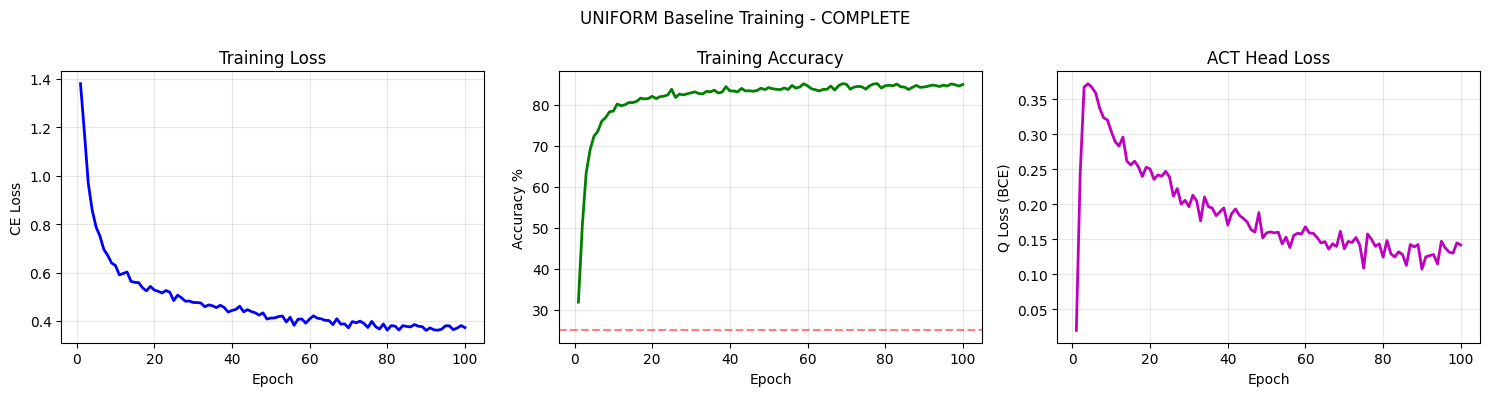


✓ Saved: checkpoints/uniform_baseline/uniform_baseline_model.pt
Final Accuracy: 84.9%


In [6]:
# =============================================================================
# UNIFORM BASELINE TRAINING (No Curriculum - Equal Difficulty Sampling)
# =============================================================================
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from models.recursive_reasoning.trm import TinyRecursiveReasoningModel_ACTV1
from models.rule_rl.train import generate_puzzle
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    'batch_size': 1, 'seq_len': 16, 'vocab_size': 6,
    'hidden_size': HIDDEN_SIZE, 'num_heads': NUM_HEADS, 'expansion': 4,
    'H_cycles': H_CYCLES, 'L_cycles': L_CYCLES, 'H_layers': 0, 'L_layers': L_LAYERS,
    'pos_encodings': 'rope', 'rms_norm_eps': 1e-5, 'rope_theta': 10000.0,
    'puzzle_emb_ndim': 0, 'puzzle_emb_len': 0, 'num_puzzle_identifiers': 1,
    'halt_max_steps': 16, 'halt_exploration_prob': 0.0, 'forward_dtype': 'bfloat16',
    'detach_early_cycles': False,  # Full gradients through all H-cycles
}

# Initialize model from scratch
uniform_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
optimizer = torch.optim.AdamW(uniform_model.parameters(), lr=3e-4, weight_decay=0.01)
print(f'Uniform Baseline Model initialized! Params: {sum(p.numel() for p in uniform_model.parameters()):,}')

# Training config defined in Cell 1: NUM_EPOCHS, BATCH_SIZE, BATCHES_PER_EPOCH

history = {'epoch': [], 'loss': [], 'acc': [], 'q_loss': []}

# Uniform difficulty distribution
weights = [0.2, 0.2, 0.2, 0.2, 0.2]
difficulties = [4, 6, 8, 10, 12]

for epoch in range(1, NUM_EPOCHS + 1):
    uniform_model.train()
    total_loss = total_correct = total_cells = total_q_loss = 0
    
    for _ in range(BATCHES_PER_EPOCH):
        # Generate batch
        puzzles, solutions = [], []
        for _ in range(BATCH_SIZE):
            diff = np.random.choice(difficulties, p=weights)
            p, s = generate_puzzle(4, diff)
            puzzles.append(p)
            solutions.append(s)
        
        puzzles = torch.stack(puzzles).to(device)
        solutions = torch.stack(solutions).to(device)
        
        batch = {'inputs': puzzles, 'puzzle_identifiers': torch.zeros(BATCH_SIZE, dtype=torch.long, device=device)}
        carry = uniform_model.initial_carry(batch)
        carry.inner_carry.z_H = carry.inner_carry.z_H.to(device)
        carry.inner_carry.z_L = carry.inner_carry.z_L.to(device)
        carry.halted = carry.halted.to(device)
        carry.steps = carry.steps.to(device)
        
        # Forward pass
        carry, outputs = uniform_model(carry, batch)
        
        logits = outputs['logits']
        mask = (puzzles == 1)
        
        # CE loss for predictions
        ce_loss = F.cross_entropy(logits[mask], solutions[mask])
        
        # Q head loss: ORIGINAL TRM DESIGN
        # Train q_halt to predict binary "sequence is exactly correct"
        # This is GENERAL - works for any task, not just Sudoku
        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            # seq_is_correct = True if ALL predictions match ground truth
            seq_is_correct = ((preds == solutions) | ~mask).all(dim=1).float()
        
        q_halt_logits = outputs['q_halt_logits']
        q_halt_loss = F.binary_cross_entropy_with_logits(q_halt_logits.squeeze(-1), seq_is_correct)
        
        # Combined loss
        loss = ce_loss + 0.5 * q_halt_loss
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(uniform_model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        total_q_loss += q_halt_loss.item()
        preds = logits.argmax(dim=-1)
        total_correct += (preds[mask] == solutions[mask]).sum().item()
        total_cells += mask.sum().item()
    
    avg_loss = total_loss / BATCHES_PER_EPOCH
    accuracy = total_correct / total_cells * 100
    avg_q_loss = total_q_loss / BATCHES_PER_EPOCH
    history['epoch'].append(epoch)
    history['loss'].append(avg_loss)
    history['acc'].append(accuracy)
    history['q_loss'].append(avg_q_loss)
    
        # Live plot (Jupyter-compatible)
    if epoch % 5 == 0 or epoch == 1:
        clear_output(wait=True)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

        ax1.plot(history['epoch'], history['loss'], 'b-', lw=2)
        ax1.set_xlabel('Epoch'); ax1.set_ylabel('CE Loss'); ax1.set_title('Training Loss')
        ax1.grid(True, alpha=0.3)

        ax2.plot(history['epoch'], history['acc'], 'g-', lw=2)
        ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy %'); ax2.set_title('Training Accuracy')
        ax2.axhline(25, color='red', ls='--', alpha=0.5, label='Random')
        ax2.grid(True, alpha=0.3)

        ax3.plot(history['epoch'], history['q_loss'], 'm-', lw=2)
        ax3.set_xlabel('Epoch'); ax3.set_ylabel('Q Loss (BCE)'); ax3.set_title('ACT Head Loss')
        ax3.grid(True, alpha=0.3)

        fig.suptitle(f'UNIFORM Baseline Training - Epoch {epoch}/{NUM_EPOCHS}')
        plt.tight_layout()
        display(fig)
        plt.close(fig)
        
        print(f'Epoch {epoch:3d}: Loss={avg_loss:.4f}, Acc={accuracy:.1f}%')

# Final plot (with ACT loss)
clear_output(wait=True)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(history['epoch'], history['loss'], 'b-', lw=2)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('CE Loss'); ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)
ax2.plot(history['epoch'], history['acc'], 'g-', lw=2)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy %'); ax2.set_title('Training Accuracy')
ax2.axhline(25, color='red', ls='--', alpha=0.5)
ax2.grid(True, alpha=0.3)
ax3.plot(history['epoch'], history['q_loss'], 'm-', lw=2)
ax3.set_xlabel('Epoch'); ax3.set_ylabel('Q Loss (BCE)'); ax3.set_title('ACT Head Loss')
ax3.grid(True, alpha=0.3)
fig.suptitle(f'UNIFORM Baseline Training - COMPLETE')
plt.tight_layout()
plt.show()

# Save
os.makedirs('checkpoints/uniform_baseline', exist_ok=True)
torch.save({
    'model': uniform_model.state_dict(),
    'config': config,
    'history': history,
    'final_accuracy': accuracy,
}, 'checkpoints/uniform_baseline/uniform_baseline_model.pt')
print(f'\n✓ Saved: checkpoints/uniform_baseline/uniform_baseline_model.pt')
print(f'Final Accuracy: {accuracy:.1f}%')

## Part 2: Pretraining with Curriculum Schedule

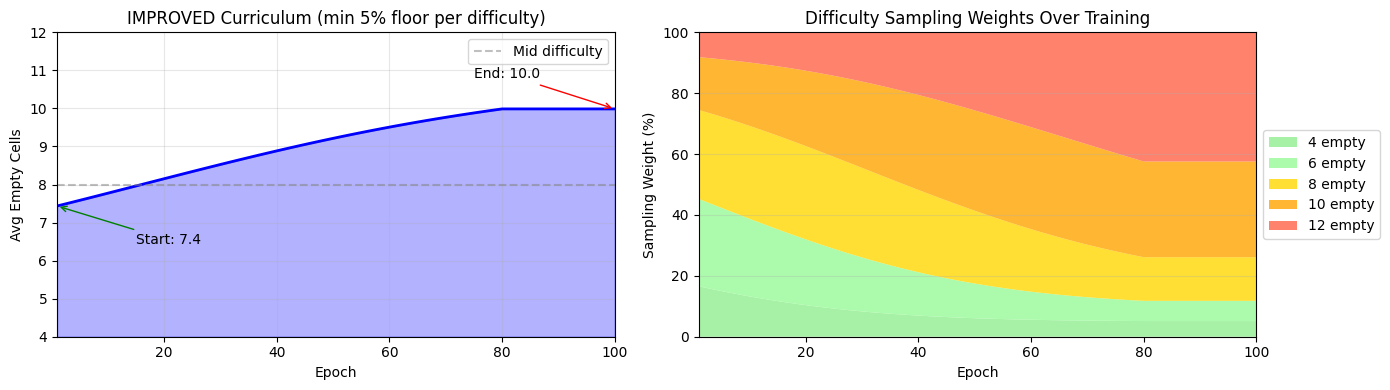

IMPROVED Curriculum Summary (Gaussian + 5% minimum floor):
  Start (epoch 1):    avg 7.4 empty cells
  Middle (epoch 50):  avg 9.2 empty cells
  End (epoch 100):   avg 10.0 empty cells
  Min weight per difficulty: 5% (prevents forgetting easy puzzles)

→ Training begins below with this schedule...


In [7]:
# Visualize Curriculum Schedule BEFORE training
NUM_EPOCHS = 100  # Define early for visualization
difficulties = [4, 6, 8, 10, 12]
epochs_range = list(range(1, NUM_EPOCHS + 1))

# ============================================================
# IMPROVED CURRICULUM: Gaussian focus + minimum floor
# - Gaussian shifts from easy→hard over training
# - BUT every difficulty keeps minimum 5% weight (prevents forgetting)
# ============================================================
MIN_WEIGHT = 0.05  # 5% minimum for each difficulty level

def get_curriculum_weights(epoch, num_epochs):
    """Smooth Gaussian-based curriculum with minimum floor to prevent forgetting."""
    progress = min(1.0, epoch / (num_epochs * 0.8))  # Saturate at 80%
    center = 1.5 + 2.5 * progress  # Start at 1.5 (intermediate), end at 4 (hard)
    sigma = 1.2  # Width of Gaussian
    
    # Gaussian weights
    weights = np.array([np.exp(-0.5 * ((i - center) / sigma) ** 2) for i in range(5)])
    weights = weights / weights.sum()
    
    # Apply minimum floor: each difficulty gets at least MIN_WEIGHT
    num_diffs = len(weights)
    floor_total = MIN_WEIGHT * num_diffs  # 25% total reserved for floors
    remaining = 1.0 - floor_total  # 75% distributed by Gaussian
    weights = MIN_WEIGHT + remaining * weights  # Floor + scaled Gaussian
    
    return weights

# Calculate expected difficulty per epoch using IMPROVED curriculum
avg_empty_per_epoch = []
weight_history = {d: [] for d in difficulties}

for e in epochs_range:
    weights = get_curriculum_weights(e, NUM_EPOCHS)
    avg_empty = sum(d * w for d, w in zip(difficulties, weights))
    avg_empty_per_epoch.append(avg_empty)
    for d, w in zip(difficulties, weights):
        weight_history[d].append(w * 100)

# Plot curriculum schedule
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: Average difficulty over time
axes[0].plot(epochs_range, avg_empty_per_epoch, 'b-', linewidth=2)
axes[0].fill_between(epochs_range, 4, avg_empty_per_epoch, alpha=0.3, color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Avg Empty Cells')
axes[0].set_title(f'IMPROVED Curriculum (min {MIN_WEIGHT*100:.0f}% floor per difficulty)')
axes[0].set_xlim(1, NUM_EPOCHS)
axes[0].set_ylim(4, 12)
axes[0].axhline(8, c='gray', ls='--', alpha=0.5, label='Mid difficulty')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Add annotations
axes[0].annotate(f'Start: {avg_empty_per_epoch[0]:.1f}', xy=(1, avg_empty_per_epoch[0]), 
                 xytext=(15, avg_empty_per_epoch[0]-1), fontsize=10,
                 arrowprops=dict(arrowstyle='->', color='green'))
axes[0].annotate(f'End: {avg_empty_per_epoch[-1]:.1f}', xy=(NUM_EPOCHS, avg_empty_per_epoch[-1]), 
                 xytext=(NUM_EPOCHS-25, avg_empty_per_epoch[-1]+0.8), fontsize=10,
                 arrowprops=dict(arrowstyle='->', color='red'))

# Right: Stacked area chart of difficulty weights
colors = ['#90EE90', '#98FB98', '#FFD700', '#FFA500', '#FF6347']  # Easy=green, Hard=red
axes[1].stackplot(epochs_range, [weight_history[d] for d in difficulties], 
                  labels=[f'{d} empty' for d in difficulties], colors=colors, alpha=0.8)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Sampling Weight (%)')
axes[1].set_title('Difficulty Sampling Weights Over Training')
axes[1].set_xlim(1, NUM_EPOCHS)
axes[1].set_ylim(0, 100)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f'IMPROVED Curriculum Summary (Gaussian + {MIN_WEIGHT*100:.0f}% minimum floor):')
print(f'  Start (epoch 1):    avg {avg_empty_per_epoch[0]:.1f} empty cells')
print(f'  Middle (epoch {NUM_EPOCHS//2}):  avg {avg_empty_per_epoch[NUM_EPOCHS//2-1]:.1f} empty cells')
print(f'  End (epoch {NUM_EPOCHS}):   avg {avg_empty_per_epoch[-1]:.1f} empty cells')
print(f'  Min weight per difficulty: {MIN_WEIGHT*100:.0f}% (prevents forgetting easy puzzles)')
print(f'\n→ Training begins below with this schedule...')


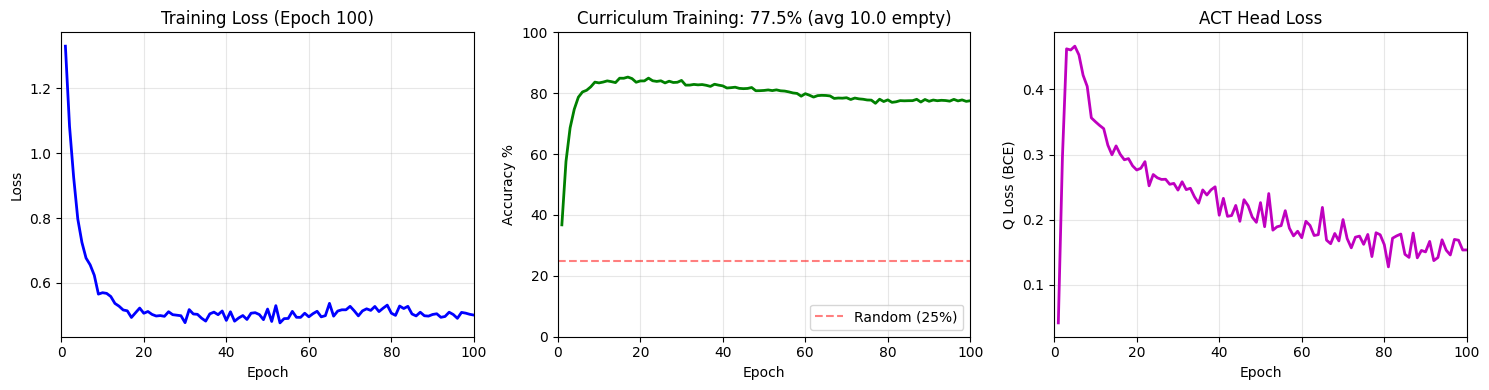

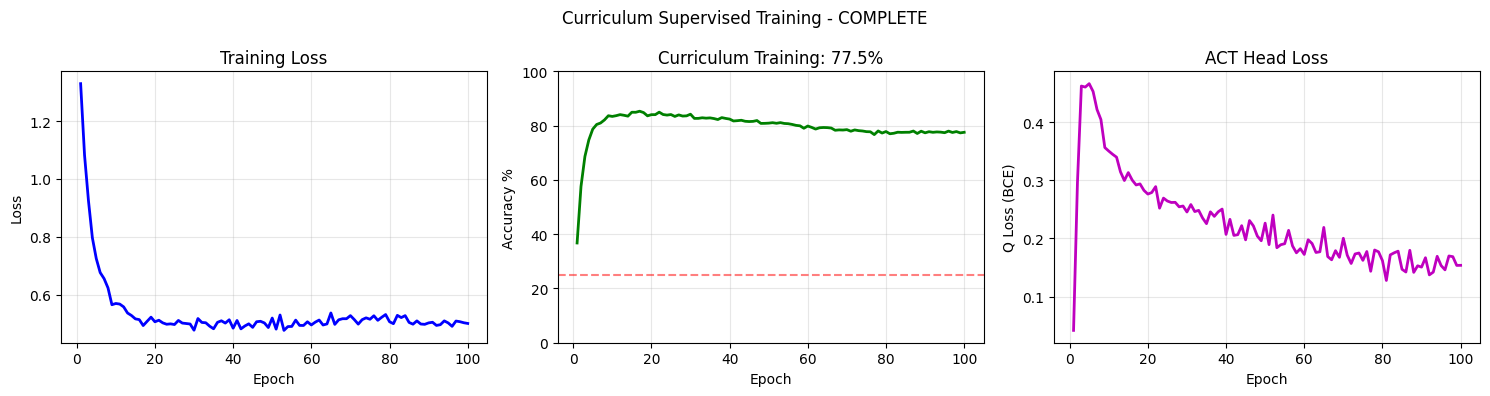


✓ Training complete! Final accuracy: 77.5%
✓ Saved to: checkpoints/curriculum_supervised/curriculum_sup_model.pt


In [8]:
# Create fresh supervised model - define config here to ensure consistency with Cell 1
from models.recursive_reasoning.trm import TinyRecursiveReasoningModel_ACTV1
from models.rule_rl.train import generate_puzzle

config = {
    'batch_size': 1, 'seq_len': 16, 'vocab_size': 6,
    'hidden_size': HIDDEN_SIZE, 'num_heads': NUM_HEADS, 'expansion': 4,
    'H_cycles': H_CYCLES, 'L_cycles': L_CYCLES, 'H_layers': 0, 'L_layers': L_LAYERS,
    'pos_encodings': 'rope', 'rms_norm_eps': 1e-5, 'rope_theta': 10000.0,
    'puzzle_emb_ndim': 0, 'puzzle_emb_len': 0, 'num_puzzle_identifiers': 1,
    'halt_max_steps': 16, 'halt_exploration_prob': 0.0, 'forward_dtype': 'bfloat16',
    'detach_early_cycles': False,  # Full gradients through all H-cycles
}

sup_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
sup_optimizer = optim.AdamW(sup_model.parameters(), lr=3e-4, weight_decay=0.01)  # Match Cell 3's lr

print(f'Fresh supervised model: {sum(p.numel() for p in sup_model.parameters()):,} params')
print(f'Architecture: H={H_CYCLES}, L={L_CYCLES}, L_layers={L_LAYERS}')
print(f'Config: {config}')

# Training loop with LIVE PLOTTING
# Training config defined in Cell 1: NUM_EPOCHS, BATCH_SIZE, BATCHES_PER_EPOCH

history = {'epoch': [], 'loss': [], 'acc': [], 'q_loss': []}
difficulties = [4, 6, 8, 10, 12]

# Setup live plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
plt.ion()  # Interactive mode

for epoch in range(1, NUM_EPOCHS + 1):
    sup_model.train()
    total_loss = total_correct = total_cells = total_q_loss = 0

    # Curriculum weights for this epoch
    weights = get_curriculum_weights(epoch, NUM_EPOCHS)
    
    for _ in range(BATCHES_PER_EPOCH):
        # Generate batch
        puzzles, solutions = [], []
        for _ in range(BATCH_SIZE):
            num_empty = np.random.choice(difficulties, p=weights)
            p, s = generate_puzzle(4, num_empty)
            puzzles.append(p)
            solutions.append(s)
        
        puzzles = torch.stack(puzzles).to(device)
        solutions = torch.stack(solutions).to(device)
        
        batch = {'inputs': puzzles, 'puzzle_identifiers': torch.zeros(BATCH_SIZE, dtype=torch.long, device=device)}
        
        carry = sup_model.initial_carry(batch)
        carry.inner_carry.z_H = carry.inner_carry.z_H.to(device)
        carry.inner_carry.z_L = carry.inner_carry.z_L.to(device)
        carry.halted = carry.halted.to(device)
        carry.steps = carry.steps.to(device)
        
        # Forward pass
        carry, outputs = sup_model(carry, batch)
        
        logits = outputs['logits']
        mask = (puzzles == 1)
        
        # CE loss for predictions
        ce_loss = F.cross_entropy(logits[mask], solutions[mask])
        
        # Q head loss: ORIGINAL TRM DESIGN
        # Train q_halt to predict binary "sequence is exactly correct"
        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            seq_is_correct = ((preds == solutions) | ~mask).all(dim=1).float()
        
        q_halt_logits = outputs['q_halt_logits']
        q_halt_loss = F.binary_cross_entropy_with_logits(q_halt_logits.squeeze(-1), seq_is_correct)
        
        # Combined loss
        loss = ce_loss + 0.5 * q_halt_loss
        
        sup_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(sup_model.parameters(), 1.0)
        sup_optimizer.step()
        
        total_loss += loss.item()
        total_q_loss += q_halt_loss.item()
        preds = logits.argmax(dim=-1)
        total_correct += (preds[mask] == solutions[mask]).sum().item()
        total_cells += mask.sum().item()
    
    avg_loss = total_loss / BATCHES_PER_EPOCH
    acc = total_correct / total_cells * 100
    avg_q_loss = total_q_loss / BATCHES_PER_EPOCH
    history['epoch'].append(epoch)
    history['loss'].append(avg_loss)
    history['acc'].append(acc)
    history['q_loss'].append(avg_q_loss)

        # Live plot update (every epoch)
    clear_output(wait=True)
    ax1.clear(); ax2.clear(); ax3.clear()

    ax1.plot(history['epoch'], history['loss'], 'b-', linewidth=2)
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
    ax1.set_title(f'Training Loss (Epoch {epoch})')
    ax1.set_xlim(0, NUM_EPOCHS)
    ax1.grid(True, alpha=0.3)

    ax2.plot(history['epoch'], history['acc'], 'g-', linewidth=2)
    ax2.axhline(y=25, color='r', linestyle='--', alpha=0.5, label='Random (25%)')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy %')
    avg_empty = sum(d * p for d, p in zip(difficulties, weights))
    ax2.set_title(f'Curriculum Training: {acc:.1f}% (avg {avg_empty:.1f} empty)')
    ax2.set_xlim(0, NUM_EPOCHS); ax2.set_ylim(0, 100)
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)

    ax3.plot(history['epoch'], history['q_loss'], 'm-', linewidth=2)
    ax3.set_xlabel('Epoch'); ax3.set_ylabel('Q Loss (BCE)')
    ax3.set_title(f'ACT Head Loss')
    ax3.set_xlim(0, NUM_EPOCHS)
    ax3.grid(True, alpha=0.3)

    fig.tight_layout()
    display(fig)

plt.ioff()
plt.close(fig)  # Close live plot

# Final plot (with ACT loss - persistent)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(history['epoch'], history['loss'], 'b-', linewidth=2)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(history['epoch'], history['acc'], 'g-', linewidth=2)
ax2.axhline(y=25, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy %')
ax2.set_title(f'Curriculum Training: {history["acc"][-1]:.1f}%')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)

ax3.plot(history['epoch'], history['q_loss'], 'm-', linewidth=2)
ax3.set_xlabel('Epoch'); ax3.set_ylabel('Q Loss (BCE)')
ax3.set_title('ACT Head Loss')
ax3.grid(True, alpha=0.3)

fig.suptitle('Curriculum Supervised Training - COMPLETE')
plt.tight_layout()
plt.show()

print(f'\n✓ Training complete! Final accuracy: {history["acc"][-1]:.1f}%')

# Auto-save the curriculum supervised model
import os
os.makedirs('checkpoints/curriculum_supervised', exist_ok=True)
save_path = 'checkpoints/curriculum_supervised/curriculum_sup_model.pt'
torch.save({
    'model_state_dict': sup_model.state_dict(),
    'history': history,
    'config': {'H': H_CYCLES, 'L': L_CYCLES, 'L_layers': L_LAYERS, 'hidden': HIDDEN_SIZE, 'num_heads': NUM_HEADS},
    'final_accuracy': history['acc'][-1],
}, save_path)
print(f'✓ Saved to: {save_path}')

## Part 3b: Uniform Supervised Training with MoE (DeepSeek-MoE)

Same curriculum training but with **Mixture of Experts** FFN layers:
- **Shared Expert**: Always-on persistent expert (captures common patterns)
- **Routed Experts**: Top-K experts selected per token (specialization)
- **Load Balancing**: Auxiliary loss prevents expert collapse


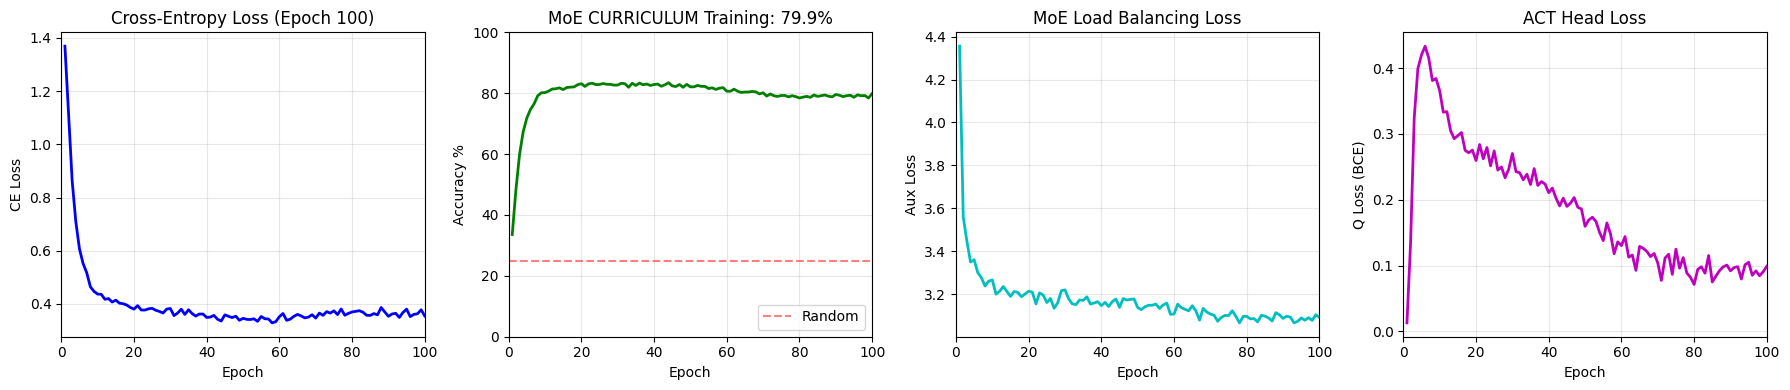

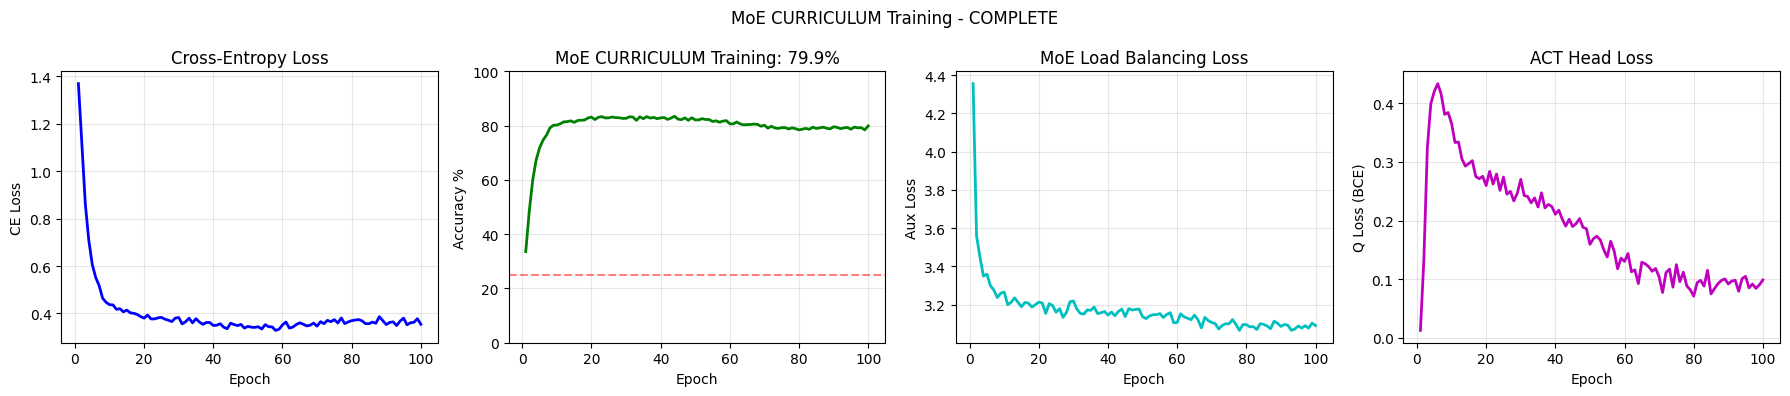


✓ MoE Training complete! Final accuracy: 79.9%
✓ Saved to: checkpoints/moe_supervised/moe_curriculum_model.pt


In [21]:
# ============================================================
# MoE Config (DeepSeek-style: shared expert + top-k routed)
# ============================================================


sup_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)  # For param count comparison only
sup_optimizer = optim.AdamW(sup_model.parameters(), lr=3e-4, weight_decay=0.01)  # Match Cell 6

MOE_NUM_EXPERTS = 16   # Number of routed experts
MOE_TOP_K = 4         # Select top-2 experts per token
MOE_SHARED = True     # Always-on shared expert
MOE_AUX_COEF = 0.01   # Load balancing loss coefficient

# Config with MoE enabled
moe_config = {
    'batch_size': 1, 'seq_len': 16, 'vocab_size': 6,
    'hidden_size': HIDDEN_SIZE, 'num_heads': NUM_HEADS, 'expansion': 4,
    'H_cycles': H_CYCLES, 'L_cycles': L_CYCLES, 'H_layers': 0, 'L_layers': L_LAYERS,
    'pos_encodings': 'rope', 'rms_norm_eps': 1e-5, 'rope_theta': 10000.0,
    'puzzle_emb_ndim': 0, 'puzzle_emb_len': 0, 'num_puzzle_identifiers': 1,
    'halt_max_steps': 16, 'halt_exploration_prob': 0.0, 'forward_dtype': 'bfloat16',
    'detach_early_cycles': False,  # Full gradients through all H-cycles
    # MoE settings
    'use_moe': True,
    'num_experts': MOE_NUM_EXPERTS,
    'top_k': MOE_TOP_K,
    'shared_expert': MOE_SHARED,
    'moe_jitter_noise': 0.01,
    'moe_aux_loss_coef': MOE_AUX_COEF,
}

# Create MoE model
moe_model = TinyRecursiveReasoningModel_ACTV1(moe_config).to(device)
moe_optimizer = optim.AdamW(moe_model.parameters(), lr=3e-4, weight_decay=0.01)  # Match Cell 6

moe_params = sum(p.numel() for p in moe_model.parameters())
base_params = sum(p.numel() for p in sup_model.parameters())
num_activated = (1 if MOE_SHARED else 0) + MOE_TOP_K
print(f'MoE Model: {moe_params:,} params ({moe_params/base_params:.2f}x baseline)')
print(f'  Architecture: H={H_CYCLES}, L={L_CYCLES}, L_layers={L_LAYERS}, num_heads={NUM_HEADS}')
print(f'  MoE Config: {MOE_NUM_EXPERTS} routed + {"1 shared" if MOE_SHARED else "no shared"}, top-{MOE_TOP_K}')
print(f'  Expert size: FFN/{num_activated} each (all experts same size)')
print(f'  Activated: {num_activated} experts × (FFN/{num_activated}) = 1.0x compute ✓')
print(f'  Total params: ({MOE_NUM_EXPERTS}+{1 if MOE_SHARED else 0}) × (FFN/{num_activated}) = ~{(MOE_NUM_EXPERTS + (1 if MOE_SHARED else 0))/num_activated:.1f}x FFN params')
print()

# Training loop with LIVE PLOTTING (CURRICULUM - uses get_curriculum_weights from Cell 5)
# Training config defined in Cell 1: NUM_EPOCHS, BATCH_SIZE, BATCHES_PER_EPOCH
# NOTE: Uses the SAME Gaussian curriculum with min floor defined in Cell 5

moe_history = {'epoch': [], 'loss': [], 'acc': [], 'aux_loss': [], 'q_loss': []}
difficulties = [4, 6, 8, 10, 12]

# Setup live plot
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
plt.ion()

for epoch in range(1, NUM_EPOCHS + 1):
    moe_model.train()
    total_loss = total_aux_loss = total_correct = total_cells = total_q_loss = 0

    # CURRICULUM weights (same schedule as Cell 6)
    weights = get_curriculum_weights(epoch, NUM_EPOCHS)
    
    for _ in range(BATCHES_PER_EPOCH):
        # Generate batch
        puzzles, solutions = [], []
        for _ in range(BATCH_SIZE):
            num_empty = np.random.choice(difficulties, p=weights)
            p, s = generate_puzzle(4, num_empty)
            puzzles.append(p)
            solutions.append(s)
        
        puzzles = torch.stack(puzzles).to(device)
        solutions = torch.stack(solutions).to(device)
        
        batch = {'inputs': puzzles, 'puzzle_identifiers': torch.zeros(BATCH_SIZE, dtype=torch.long, device=device)}
        
        carry = moe_model.initial_carry(batch)
        carry.inner_carry.z_H = carry.inner_carry.z_H.to(device)
        carry.inner_carry.z_L = carry.inner_carry.z_L.to(device)
        carry.halted = carry.halted.to(device)
        carry.steps = carry.steps.to(device)
        
        # Forward pass
        carry, outputs = moe_model(carry, batch)
        
        logits = outputs['logits']
        mask = (puzzles == 1)
        
        # Main loss + MoE auxiliary loss (load balancing)
        ce_loss = F.cross_entropy(logits[mask], solutions[mask])
        
        # Q head loss: ORIGINAL TRM DESIGN
        # Train q_halt to predict binary "sequence is exactly correct"
        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            seq_is_correct = ((preds == solutions) | ~mask).all(dim=1).float()
        
        q_halt_logits = outputs['q_halt_logits']
        q_halt_loss = F.binary_cross_entropy_with_logits(q_halt_logits.squeeze(-1), seq_is_correct)
        
        # Combine losses
        aux_loss = outputs.get('aux_loss', None)
        if aux_loss is not None:
            loss = ce_loss + 0.5 * q_halt_loss + MOE_AUX_COEF * aux_loss
            total_aux_loss += aux_loss.item()
        else:
            loss = ce_loss + 0.5 * q_halt_loss
        
        moe_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(moe_model.parameters(), 1.0)
        moe_optimizer.step()
        
        total_loss += ce_loss.item()
        total_q_loss += q_halt_loss.item()
        preds = logits.argmax(dim=-1)
        total_correct += (preds[mask] == solutions[mask]).sum().item()
        total_cells += mask.sum().item()
    
    acc = total_correct / total_cells * 100
    moe_history['epoch'].append(epoch)
    moe_history['loss'].append(total_loss / BATCHES_PER_EPOCH)
    moe_history['acc'].append(acc)
    moe_history['aux_loss'].append(total_aux_loss / BATCHES_PER_EPOCH)
    moe_history['q_loss'].append(total_q_loss / BATCHES_PER_EPOCH)

    # Live plot update
    clear_output(wait=True)
    for ax in axes: ax.clear()
    
    axes[0].plot(moe_history['epoch'], moe_history['loss'], 'b-', linewidth=2)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('CE Loss')
    axes[0].set_title(f'Cross-Entropy Loss (Epoch {epoch})')
    axes[0].set_xlim(0, NUM_EPOCHS)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(moe_history['epoch'], moe_history['acc'], 'g-', linewidth=2)
    axes[1].axhline(y=25, color='r', linestyle='--', alpha=0.5, label='Random')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy %')
    axes[1].set_title(f'MoE CURRICULUM Training: {acc:.1f}%')
    axes[1].set_xlim(0, NUM_EPOCHS); axes[1].set_ylim(0, 100)
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(moe_history['epoch'], moe_history['aux_loss'], 'c-', linewidth=2)
    axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Aux Loss')
    axes[2].set_title(f'MoE Load Balancing Loss')
    axes[2].set_xlim(0, NUM_EPOCHS)
    axes[2].grid(True, alpha=0.3)

    axes[3].plot(moe_history['epoch'], moe_history['q_loss'], 'm-', linewidth=2)
    axes[3].set_xlabel('Epoch'); axes[3].set_ylabel('Q Loss (BCE)')
    axes[3].set_title(f'ACT Head Loss')
    axes[3].set_xlim(0, NUM_EPOCHS)
    axes[3].grid(True, alpha=0.3)

    fig.tight_layout()
    display(fig)

plt.ioff()
plt.close(fig)  # Close live plot

# Final plot (with ACT loss - persistent)
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
axes[0].plot(moe_history['epoch'], moe_history['loss'], 'b-', linewidth=2)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('CE Loss')
axes[0].set_title('Cross-Entropy Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(moe_history['epoch'], moe_history['acc'], 'g-', linewidth=2)
axes[1].axhline(y=25, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy %')
axes[1].set_title(f'MoE CURRICULUM Training: {moe_history["acc"][-1]:.1f}%')
axes[1].set_ylim(0, 100)
axes[1].grid(True, alpha=0.3)

axes[2].plot(moe_history['epoch'], moe_history['aux_loss'], 'c-', linewidth=2)
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Aux Loss')
axes[2].set_title('MoE Load Balancing Loss')
axes[2].grid(True, alpha=0.3)

axes[3].plot(moe_history['epoch'], moe_history['q_loss'], 'm-', linewidth=2)
axes[3].set_xlabel('Epoch'); axes[3].set_ylabel('Q Loss (BCE)')
axes[3].set_title('ACT Head Loss')
axes[3].grid(True, alpha=0.3)

fig.suptitle('MoE CURRICULUM Training - COMPLETE')
plt.tight_layout()
plt.show()

print(f'\n✓ MoE Training complete! Final accuracy: {moe_history["acc"][-1]:.1f}%')

# Auto-save the MoE model
import os
os.makedirs('checkpoints/moe_supervised', exist_ok=True)
save_path = 'checkpoints/moe_supervised/moe_curriculum_model.pt'
torch.save({
    'model_state_dict': moe_model.state_dict(),
    'history': moe_history,
    'config': {'H': H_CYCLES, 'L': L_CYCLES, 'L_layers': L_LAYERS, 'hidden': HIDDEN_SIZE, 'num_heads': NUM_HEADS,
               'num_experts': MOE_NUM_EXPERTS, 'top_k': MOE_TOP_K, 'shared_expert': MOE_SHARED,
               'training': 'curriculum'},
    'final_accuracy': moe_history['acc'][-1],
}, save_path)
print(f'✓ Saved to: {save_path}')


✓ Loaded Baseline history: 100 epochs
✓ Loaded Curriculum history: 100 epochs
✓ Loaded MoE history: 100 epochs

✓ Saved: tests/act_loss_comparison.png


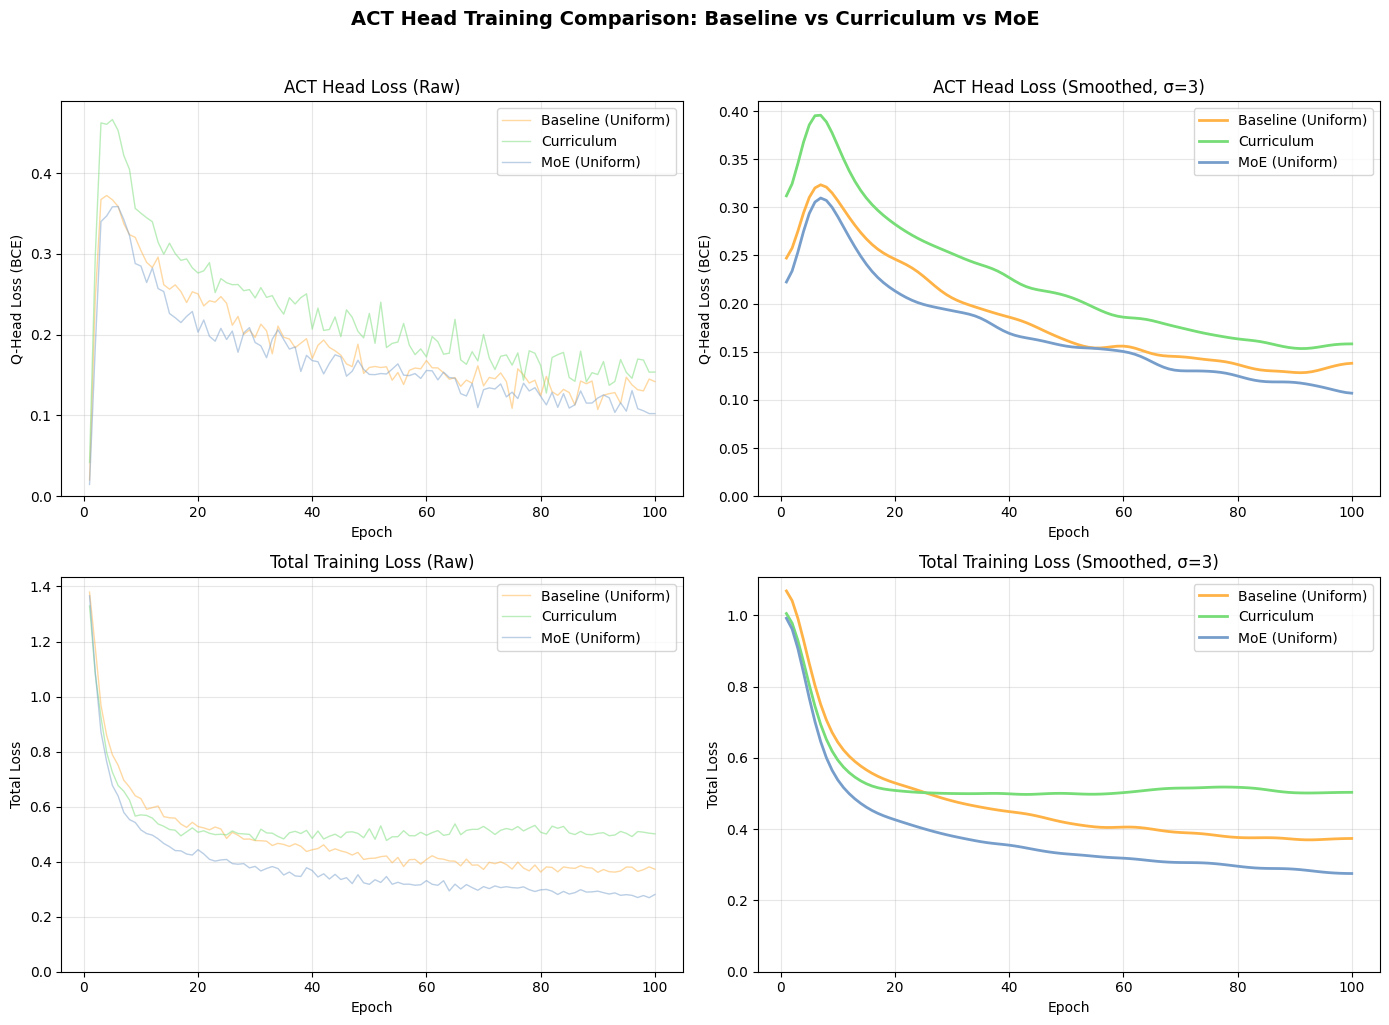


FINAL ACT (Q-HEAD) LOSS VALUES
Model                Final Q-Loss    Final Total Loss
----------------------------------------------------------------------
Baseline (Uniform)   0.1419          0.3726         
Curriculum           0.1538          0.5011         
MoE (Uniform)        0.1023          0.2806         

INTERPRETATION:
  - Lower Q-loss = better at predicting sequence correctness
  - Q-loss is trained with BCE: target=1 if ALL predictions correct
  - Early training: Q-loss high (predictions mostly wrong)
  - Late training: Q-loss should decrease as accuracy improves


In [22]:
# =============================================================================
# SMOOTHED ACT HEAD LOSS VISUALIZATION
# =============================================================================
# Compare ACT (Q-head) loss convergence across all three models

import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load training histories from checkpoints
histories = {}

# 1. Baseline (Uniform)
try:
    baseline_ckpt = torch.load('checkpoints/uniform_baseline/uniform_baseline_model.pt', map_location=device)
    if 'history' in baseline_ckpt and 'q_loss' in baseline_ckpt['history']:
        histories['Baseline (Uniform)'] = baseline_ckpt['history']
        print(f"✓ Loaded Baseline history: {len(baseline_ckpt['history']['epoch'])} epochs")
    else:
        print("⚠️ Baseline checkpoint missing q_loss history - re-run Cell 3")
except FileNotFoundError:
    print("⚠️ Baseline checkpoint not found - run Cell 3 first")

# 2. Curriculum
try:
    curr_ckpt = torch.load('checkpoints/curriculum_supervised/curriculum_sup_model.pt', map_location=device)
    if 'history' in curr_ckpt and 'q_loss' in curr_ckpt['history']:
        histories['Curriculum'] = curr_ckpt['history']
        print(f"✓ Loaded Curriculum history: {len(curr_ckpt['history']['epoch'])} epochs")
    else:
        print("⚠️ Curriculum checkpoint missing q_loss history - re-run Cell 6")
except FileNotFoundError:
    print("⚠️ Curriculum checkpoint not found - run Cell 6 first")

# 3. MoE (Uniform)
try:
    moe_ckpt = torch.load('checkpoints/moe_supervised/moe_uniform_model.pt', map_location=device)
    if 'history' in moe_ckpt and 'q_loss' in moe_ckpt['history']:
        histories['MoE (Uniform)'] = moe_ckpt['history']
        print(f"✓ Loaded MoE history: {len(moe_ckpt['history']['epoch'])} epochs")
    else:
        print("⚠️ MoE checkpoint missing q_loss history - re-run Cell 8")
except FileNotFoundError:
    print("⚠️ MoE checkpoint not found - run Cell 8 first")

if not histories:
    print("\n❌ No training histories with q_loss found.")
    print("   Re-run training cells (3, 6, 8) to generate q_loss history.")
else:
    # Smoothing parameters
    SMOOTHING_SIGMA = 3  # Gaussian smoothing sigma (higher = smoother)
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = {
        'Baseline (Uniform)': '#FFB347',  # Orange
        'Curriculum': '#77DD77',           # Green
        'MoE (Uniform)': '#779ECB'         # Blue
    }
    
    # =========================================================================
    # Plot 1: Raw ACT (Q-head) Loss
    # =========================================================================
    ax = axes[0, 0]
    for name, hist in histories.items():
        epochs = hist['epoch']
        q_loss = hist['q_loss']
        ax.plot(epochs, q_loss, label=name, color=colors.get(name, 'gray'), 
                linewidth=1, alpha=0.5)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Q-Head Loss (BCE)')
    ax.set_title('ACT Head Loss (Raw)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    # =========================================================================
    # Plot 2: Smoothed ACT (Q-head) Loss
    # =========================================================================
    ax = axes[0, 1]
    for name, hist in histories.items():
        epochs = np.array(hist['epoch'])
        q_loss = np.array(hist['q_loss'])
        # Apply Gaussian smoothing
        q_loss_smooth = gaussian_filter1d(q_loss, sigma=SMOOTHING_SIGMA)
        ax.plot(epochs, q_loss_smooth, label=name, color=colors.get(name, 'gray'), 
                linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Q-Head Loss (BCE)')
    ax.set_title(f'ACT Head Loss (Smoothed, σ={SMOOTHING_SIGMA})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    # =========================================================================
    # Plot 3: Raw Total Training Loss
    # =========================================================================
    ax = axes[1, 0]
    for name, hist in histories.items():
        epochs = hist['epoch']
        loss = hist['loss']
        ax.plot(epochs, loss, label=name, color=colors.get(name, 'gray'), 
                linewidth=1, alpha=0.5)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Total Loss')
    ax.set_title('Total Training Loss (Raw)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    # =========================================================================
    # Plot 4: Smoothed Total Training Loss
    # =========================================================================
    ax = axes[1, 1]
    for name, hist in histories.items():
        epochs = np.array(hist['epoch'])
        loss = np.array(hist['loss'])
        loss_smooth = gaussian_filter1d(loss, sigma=SMOOTHING_SIGMA)
        ax.plot(epochs, loss_smooth, label=name, color=colors.get(name, 'gray'), 
                linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Total Loss')
    ax.set_title(f'Total Training Loss (Smoothed, σ={SMOOTHING_SIGMA})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    plt.suptitle('ACT Head Training Comparison: Baseline vs Curriculum vs MoE', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('tests/act_loss_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
    print('\n✓ Saved: tests/act_loss_comparison.png')
    plt.show()
    
    # Print final values
    print('\n' + '='*70)
    print('FINAL ACT (Q-HEAD) LOSS VALUES')
    print('='*70)
    print(f'{"Model":<20} {"Final Q-Loss":<15} {"Final Total Loss":<15}')
    print('-'*70)
    for name, hist in histories.items():
        final_q = hist['q_loss'][-1]
        final_total = hist['loss'][-1]
        print(f'{name:<20} {final_q:<15.4f} {final_total:<15.4f}')
    print()
    print('INTERPRETATION:')
    print('  - Lower Q-loss = better at predicting sequence correctness')
    print('  - Q-loss is trained with BCE: target=1 if ALL predictions correct')
    print('  - Early training: Q-loss high (predictions mostly wrong)')
    print('  - Late training: Q-loss should decrease as accuracy improves')

In [23]:
# =============================================================================
# INSPECT ACT Q-HEAD VALUES
# =============================================================================
# This cell diagnoses why ACT always halts at step 1

import torch
from models.recursive_reasoning.trm import TinyRecursiveReasoningModel_ACTV1
from models.rule_rl.train import generate_puzzle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained baseline model
print("Loading trained model...")
ckpt = torch.load('checkpoints/uniform_baseline/uniform_baseline_model.pt', map_location=device)

config = {
    'batch_size': 1, 'seq_len': 16, 'vocab_size': 6,
    'hidden_size': HIDDEN_SIZE, 'num_heads': NUM_HEADS, 'expansion': 4,
    'H_cycles': H_CYCLES, 'L_cycles': L_CYCLES, 'H_layers': 0, 'L_layers': L_LAYERS,
    'pos_encodings': 'rope', 'rms_norm_eps': 1e-5, 'rope_theta': 10000.0,
    'puzzle_emb_ndim': 0, 'puzzle_emb_len': 0, 'num_puzzle_identifiers': 1,
    'halt_max_steps': 16, 'halt_exploration_prob': 0.0, 'forward_dtype': 'float32',
    'detach_early_cycles': False,
}

model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
model.load_state_dict(ckpt['model'])
model.eval()

# Inspect Q-head parameters
print("\n" + "="*60)
print("Q-HEAD PARAMETERS")
print("="*60)
q_weight = model.inner.q_head.weight.data
q_bias = model.inner.q_head.bias.data
print(f"Weight shape: {q_weight.shape}")
print(f"Bias: q_halt={q_bias[0].item():.4f}, q_continue={q_bias[1].item():.4f}")
print(f"Weight norm: row0={q_weight[0].norm().item():.4f}, row1={q_weight[1].norm().item():.4f}")

# Test on different difficulties
print("\n" + "="*60)
print("Q-HEAD OUTPUTS AT DIFFERENT DIFFICULTIES")
print("="*60)
print("ORIGINAL TRM DESIGN: Halt if q_halt > 0 (predicts exact correctness)")
print("-"*60)
print(f"{'Difficulty':<12} {'q_halt':>10} {'sigmoid':>10} {'Halt?':>8}")
print("-"*60)

for num_empty in [4, 6, 8, 10, 12]:
    # Generate multiple puzzles and average
    q_halts = []
    
    for _ in range(10):
        puzzle, solution = generate_puzzle(4, num_empty)
        puzzle_t = puzzle.unsqueeze(0).to(device)
        batch = {'inputs': puzzle_t, 'puzzle_identifiers': torch.zeros(1, dtype=torch.long, device=device)}
        
        carry = model.initial_carry(batch)
        carry.inner_carry.z_H = carry.inner_carry.z_H.to(device)
        carry.inner_carry.z_L = carry.inner_carry.z_L.to(device)
        carry.halted = carry.halted.to(device)
        carry.steps = carry.steps.to(device)
        
        with torch.no_grad():
            carry, outputs = model(carry, batch)
        
        q_halts.append(outputs['q_halt_logits'].item())
    
    avg_halt = np.mean(q_halts)
    sig = 1 / (1 + np.exp(-avg_halt))  # sigmoid(q_halt)
    halted = avg_halt > 0  # ORIGINAL: halt if q_halt > 0
    
    print(f"{num_empty} empty    {avg_halt:>10.3f} {sig:>10.3f} {'YES' if halted else 'NO':>8}")

# Explain the issue
print("\n" + "="*60)
print("DIAGNOSIS (ORIGINAL TRM DESIGN)")
print("="*60)

q_halt_bias = q_bias[0].item()

print(f"q_halt bias: {q_halt_bias:.3f}")
print(f"Halting threshold: 0 (halt if q_halt > 0)")
print()

if q_halt_bias > 2:
    print("⚠️  q_halt bias is HIGH → model tends to always halt")
    print("   This happens when training samples are mostly correct.")
elif q_halt_bias < -2:
    print("✓ q_halt bias is LOW → model tends to continue")
    print("   This is expected early in training (predictions mostly wrong).")
else:
    print("✓ q_halt bias is moderate → halting depends on input")

# Check if weights learned anything
w0_norm = q_weight[0].norm().item()
print()
print(f"q_halt weight norm: {w0_norm:.3f}")
if w0_norm < 0.5:
    print("⚠️  Weights are small - halting dominated by bias, not input-dependent")
else:
    print("✓ Weights have learned - halting is input-dependent")

print()
print("INTERPRETATION:")
print("  - sigmoid(q_halt) = P(sequence is exactly correct)")
print("  - Halt if q_halt > 0, i.e., P(correct) > 50%")
print("  - SPARSE SIGNAL: Only 1 when ALL predictions match ground truth")


Loading trained model...

Q-HEAD PARAMETERS
Weight shape: torch.Size([2, 128])
Bias: q_halt=-4.7210, q_continue=-4.8531
Weight norm: row0=1.2728, row1=0.0000

Q-HEAD OUTPUTS AT DIFFERENT DIFFICULTIES
ORIGINAL TRM DESIGN: Halt if q_halt > 0 (predicts exact correctness)
------------------------------------------------------------
Difficulty       q_halt    sigmoid    Halt?
------------------------------------------------------------
4 empty         6.824      0.999      YES
6 empty         4.975      0.993      YES
8 empty         3.447      0.969      YES
10 empty         0.832      0.697      YES
12 empty        -3.415      0.032       NO

DIAGNOSIS (ORIGINAL TRM DESIGN)
q_halt bias: -4.721
Halting threshold: 0 (halt if q_halt > 0)

✓ q_halt bias is LOW → model tends to continue
   This is expected early in training (predictions mostly wrong).

q_halt weight norm: 1.273
✓ Weights have learned - halting is input-dependent

INTERPRETATION:
  - sigmoid(q_halt) = P(sequence is exactly corr

Device: cuda
Loading checkpoints for comparison...
  Baseline: checkpoints/uniform_baseline/uniform_baseline_model.pt
    Config: {'batch_size': 1, 'seq_len': 16, 'vocab_size': 6, 'hidden_size': 128, 'num_heads': 4, 'expansion': 4, 'H_cycles': 2, 'L_cycles': 4, 'H_layers': 0, 'L_layers': 3, 'pos_encodings': 'rope', 'rms_norm_eps': 1e-05, 'rope_theta': 10000.0, 'puzzle_emb_ndim': 0, 'puzzle_emb_len': 0, 'num_puzzle_identifiers': 1, 'halt_max_steps': 16, 'halt_exploration_prob': 0.0, 'forward_dtype': 'bfloat16', 'detach_early_cycles': False}
    Final accuracy: 84.9%
  Curriculum: checkpoints/curriculum_supervised/curriculum_sup_model.pt
    Config: {'H': 2, 'L': 4, 'L_layers': 3, 'hidden': 128, 'num_heads': 4}
    Final accuracy: 77.5%
  MoE (Curriculum): checkpoints/moe_supervised/moe_curriculum_model.pt
    Config: {'H': 2, 'L': 4, 'L_layers': 3, 'hidden': 128, 'num_heads': 4, 'num_experts': 16, 'top_k': 4, 'shared_expert': True, 'training': 'curriculum'}
    Final accuracy: 79.9%

MO

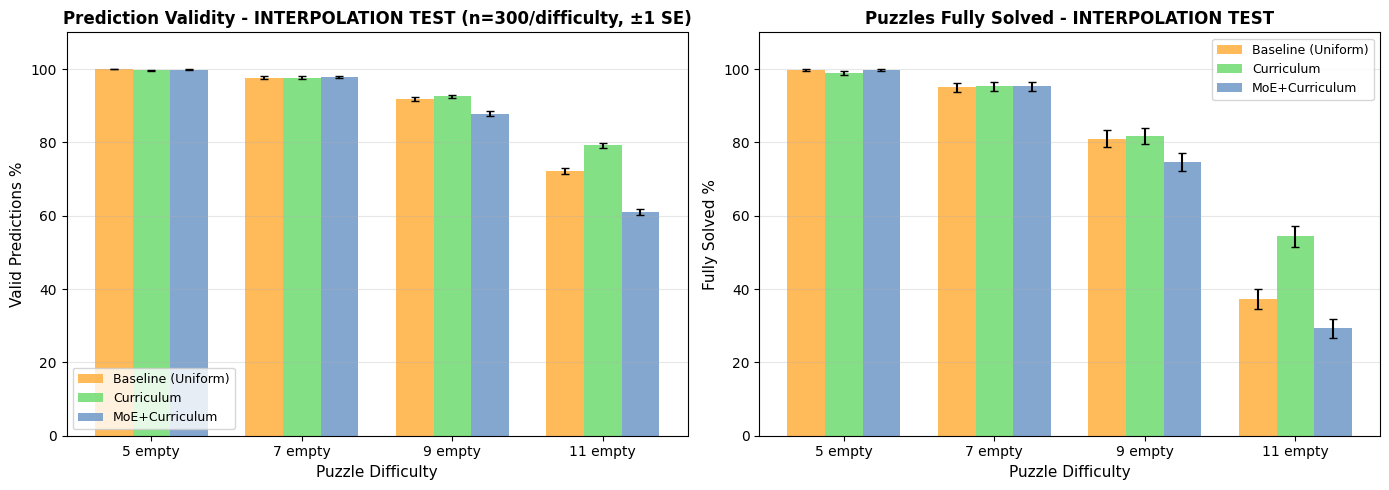

In [ ]:
# ============================================================
# COMPARISON: Regular Supervised vs MoE Supervised
# ============================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from models.recursive_reasoning.trm import TinyRecursiveReasoningModel_ACTV1
from models.rule_rl.train import generate_puzzle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# ACT Configuration
USE_TRUE_ACT = True   # True = let model decide when to halt (up to MAX_ACT_STEPS)
MAX_ACT_STEPS = 16    # Maximum ACT iterations (matches original paper's halt_max_steps)

# Base config for non-MoE models
config = {
    'batch_size': 1, 'seq_len': 16, 'vocab_size': 6,
    'hidden_size': HIDDEN_SIZE, 'num_heads': NUM_HEADS, 'expansion': 4,
    'H_cycles': H_CYCLES, 'L_cycles': L_CYCLES, 'H_layers': 0, 'L_layers': L_LAYERS,
    'pos_encodings': 'rope', 'rms_norm_eps': 1e-5, 'rope_theta': 10000.0,
    'puzzle_emb_ndim': 0, 'puzzle_emb_len': 0, 'num_puzzle_identifiers': 1,
    'halt_max_steps': 16, 'halt_exploration_prob': 0.0, 'forward_dtype': 'bfloat16',
    'detach_early_cycles': False,
}

# MoE config
MOE_NUM_EXPERTS = 16
MOE_TOP_K = 4
MOE_SHARED = True

moe_config = {
    **config,
    'use_moe': True,
    'num_experts': MOE_NUM_EXPERTS,
    'top_k': MOE_TOP_K,
    'shared_expert': MOE_SHARED,
}

# Load checkpoints to ensure we're testing the saved models
print('Loading checkpoints for comparison...')

# 1. Baseline (uniform-mix trained - same architecture, no curriculum)
baseline_ckpt = 'checkpoints/uniform_baseline/uniform_baseline_model.pt'
print(f'  Baseline: {baseline_ckpt}')
ckpt = torch.load(baseline_ckpt, map_location=device)
baseline_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
# Our checkpoint saves state_dict under 'model' key
baseline_model.load_state_dict(ckpt['model'])
baseline_model.eval()
print(f'    Config: {ckpt.get("config", {})}')
print(f'    Final accuracy: {ckpt.get("final_accuracy", "N/A"):.1f}%')

# 2. Curriculum supervised
curriculum_ckpt = 'checkpoints/curriculum_supervised/curriculum_sup_model.pt'
print(f'  Curriculum: {curriculum_ckpt}')
ckpt = torch.load(curriculum_ckpt, map_location=device)
sup_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
sup_model.load_state_dict(ckpt['model_state_dict'])
sup_model.eval()
print(f'    Config: {ckpt.get("config", {})}')
print(f'    Final accuracy: {ckpt.get("final_accuracy", "N/A"):.1f}%')

# 3. MoE supervised
moe_ckpt = 'checkpoints/moe_supervised/moe_uniform_model.pt'
print(f'  MoE (Uniform): {moe_ckpt}')
ckpt = torch.load(moe_ckpt, map_location=device)
moe_model = TinyRecursiveReasoningModel_ACTV1(moe_config).to(device)
moe_model.load_state_dict(ckpt['model_state_dict'])
moe_model.eval()
print(f'    Config: {ckpt.get("config", {})}')
print(f'    Final accuracy: {ckpt.get("final_accuracy", "N/A"):.1f}%')

print()

def count_prediction_validity(board, mask, size=4):
    """Count how many of the MODEL's predictions are valid (don't violate constraints).
    
    Args:
        board: completed board (with predictions filled in)
        mask: boolean mask of which cells were predictions (True = model predicted)
        size: grid size
    
    Returns:
        (valid_predictions, total_predictions)
    """
    board = board.cpu().numpy() if torch.is_tensor(board) else board
    mask = mask.cpu().numpy() if torch.is_tensor(mask) else mask
    board = board.reshape(size, size)
    mask = mask.reshape(size, size)
    
    valid = 0
    total = mask.sum()  # Only count predicted cells
    
    box_size = int(size ** 0.5)
    
    for r in range(size):
        for c in range(size):
            if not mask[r, c]:  # Skip clues (given cells)
                continue
            
            val = board[r, c]
            is_valid = True
            
            # Check if value is in valid range
            if not (1 <= val <= size):
                is_valid = False
            else:
                # Check row (excluding self)
                row_vals = [board[r, cc] for cc in range(size) if cc != c]
                if val in row_vals:
                    is_valid = False
                
                # Check column (excluding self)
                col_vals = [board[rr, c] for rr in range(size) if rr != r]
                if val in col_vals:
                    is_valid = False
                
                # Check box (excluding self)
                box_r, box_c = (r // box_size) * box_size, (c // box_size) * box_size
                box_vals = [board[rr, cc] for rr in range(box_r, box_r + box_size) 
                                          for cc in range(box_c, box_c + box_size)
                                          if (rr, cc) != (r, c)]
                if val in box_vals:
                    is_valid = False
            
            if is_valid:
                valid += 1
    
    return valid, total

def test_model_accuracy(model, num_empty, num_samples=200):
    """Test model: prediction validity rate (how many predicted cells are correct)."""
    model.eval()
    total_valid = 0
    total_predictions = 0
    fully_solved = 0
    total_act_steps = 0  # Track ACT steps
    
    for _ in range(num_samples):
        puzzle, solution = generate_puzzle(4, num_empty)
        puzzle_t = puzzle.unsqueeze(0).to(device)
        batch = {'inputs': puzzle_t, 'puzzle_identifiers': torch.zeros(1, dtype=torch.long, device=device)}
        
        carry = model.initial_carry(batch)
        carry.inner_carry.z_H = carry.inner_carry.z_H.to(device)
        carry.inner_carry.z_L = carry.inner_carry.z_L.to(device)
        carry.halted = carry.halted.to(device)
        carry.steps = carry.steps.to(device)
        
        with torch.no_grad():
            # Run at least one forward pass, then let ACT Q-head decide when to halt
            # NOTE: carry.halted doesn't work in eval mode, so we manually check q_halt
            carry, outputs = model(carry, batch)
            act_steps = 1
            
            # ACT halting: ORIGINAL TRM DESIGN
            # q_halt > 0 means "confident that sequence is correct"
            q_halt = outputs['q_halt_logits']
            halted = (q_halt > 0)
            
            while not halted.all() and act_steps < MAX_ACT_STEPS:
                carry, outputs = model(carry, batch)
                q_halt = outputs['q_halt_logits']
                halted = (q_halt > 0)
                act_steps += 1
        
        total_act_steps += act_steps  # Accumulate ACT steps
        
        # Token predictions: 2-5 map to digits 1-4
        # Token 1 = empty, Token 2 = digit 1, ..., Token 5 = digit 4
        preds = outputs['logits'].argmax(dim=-1)[0]
        mask = (puzzle == 1)  # Empty cells
        
        # Complete the puzzle: convert token indices to digit values
        completed = puzzle.clone()
        completed[mask] = preds[mask.to(device)].cpu()
        
        # Convert from token space (2-5) to digit space (1-4) for validation
        completed_digits = completed - 1  # Shift: 2->1, 3->2, etc.
        
        # Count how many PREDICTIONS (not clues) are valid
        valid, total = count_prediction_validity(completed_digits, mask, size=4)
        total_valid += valid
        total_predictions += total
        
        if valid == total:  # All predictions valid = puzzle solved
            fully_solved += 1
    
    prediction_rate = total_valid / total_predictions * 100 if total_predictions > 0 else 0
    solve_rate = fully_solved / num_samples * 100
    avg_act_steps = total_act_steps / num_samples  # Average ACT steps
    
    # SE for prediction rate
    p = total_valid / total_predictions if total_predictions > 0 else 0
    se = np.sqrt(p * (1 - p) / total_predictions) * 100 if total_predictions > 0 else 0
    
    return {
        'acc': prediction_rate,  # % of PREDICTIONS that are valid (not diluted by clues!)
        'se': se,
        'solve_rate': solve_rate,  # % fully solved (binary)
        'act_steps': avg_act_steps,  # Average ACT halting steps
        'n': num_samples,
        'total_preds': total_predictions  # For reference
    }

def significance_test(acc1, se1, acc2, se2, n):
    """Two-proportion z-test for significance."""
    pooled_se = np.sqrt(se1**2 + se2**2)
    if pooled_se == 0:
        return 0, 1.0
    z = (acc1 - acc2) / pooled_se
    p_value = 2 * (1 - 0.5 * (1 + np.sign(z) * (1 - np.exp(-2 * (z/1.4142)**2))))  # Approx
    # More accurate: from scipy.stats import norm; p_value = 2 * (1 - norm.cdf(abs(z)))
    return z, p_value

def sig_symbol(p):
    """Return significance symbol."""
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'ns'

NUM_SAMPLES = 300  # Sample size per difficulty

print('='*120)
print('MODEL COMPARISON: Prediction Validity Rate + ACT Halting Steps')
print(f'(n={NUM_SAMPLES} puzzles per difficulty, measuring ONLY the empty cells model fills)')
print('='*120)
print()
print(f'{"Empty":<8} {"Baseline":<28} {"Curriculum":<28} {"MoE":<28}')
print('-'*100)

results = {'baseline': [], 'curriculum': [], 'moe': []}
results_se = {'baseline': [], 'curriculum': [], 'moe': []}
solve_rates = {'baseline': [], 'curriculum': [], 'moe': []}
act_steps = {'baseline': [], 'curriculum': [], 'moe': []}

for num_empty in [5, 7, 9, 11]:  # Test interpolation (odd numbers not in training)
    r_base = test_model_accuracy(baseline_model, num_empty, NUM_SAMPLES)
    r_curr = test_model_accuracy(sup_model, num_empty, NUM_SAMPLES)
    r_moe = test_model_accuracy(moe_model, num_empty, NUM_SAMPLES)
    
    results['baseline'].append(r_base['acc'])
    results['curriculum'].append(r_curr['acc'])
    results['moe'].append(r_moe['acc'])
    results_se['baseline'].append(r_base['se'])
    results_se['curriculum'].append(r_curr['se'])
    results_se['moe'].append(r_moe['se'])
    solve_rates['baseline'].append(r_base['solve_rate'])
    solve_rates['curriculum'].append(r_curr['solve_rate'])
    solve_rates['moe'].append(r_moe['solve_rate'])
    act_steps['baseline'].append(r_base['act_steps'])
    act_steps['curriculum'].append(r_curr['act_steps'])
    act_steps['moe'].append(r_moe['act_steps'])
    
    print(f'{num_empty:<8} {r_base["acc"]:>5.1f}% ±{r_base["se"]:.1f} (ACT:{r_base["act_steps"]:>4.1f})   {r_curr["acc"]:>5.1f}% ±{r_curr["se"]:.1f} (ACT:{r_curr["act_steps"]:>4.1f})   {r_moe["acc"]:>5.1f}% ±{r_moe["se"]:.1f} (ACT:{r_moe["act_steps"]:>4.1f})')

print('-'*100)
avg_base = np.mean(results['baseline'])
avg_curr = np.mean(results['curriculum'])
avg_moe = np.mean(results['moe'])
avg_solve_base = np.mean(solve_rates['baseline'])
avg_solve_curr = np.mean(solve_rates['curriculum'])
avg_solve_moe = np.mean(solve_rates['moe'])
avg_act_base = np.mean(act_steps['baseline'])
avg_act_curr = np.mean(act_steps['curriculum'])
avg_act_moe = np.mean(act_steps['moe'])
print(f'{"AVG":<8} {avg_base:>5.1f}% (ACT:{avg_act_base:>4.1f})        {avg_curr:>5.1f}% (ACT:{avg_act_curr:>4.1f})        {avg_moe:>5.1f}% (ACT:{avg_act_moe:>4.1f})')
print()
print('Note: Prediction % = valid predictions / total empty cells filled (only model outputs!)')
print('      ACT = average halting steps (1-16, lower = more confident)')
print()

# Fully Solved Rate Table
print('='*100)
print('FULLY SOLVED RATE (% of puzzles where ALL predictions are valid)')
print('='*100)
print()
print(f'{"Empty":<8} {"Baseline":<28} {"Curriculum":<28} {"MoE":<28}')
print('-'*100)

# Calculate SE for solve rates (binomial)
solve_se_vals = {'baseline': [], 'curriculum': [], 'moe': []}
for key in ['baseline', 'curriculum', 'moe']:
    solve_se_vals[key] = [np.sqrt(p/100 * (1 - p/100) / NUM_SAMPLES) * 100 for p in solve_rates[key]]

for i, num_empty in enumerate([5, 7, 9, 11]):
    print(f'{num_empty:<8} {solve_rates["baseline"][i]:>5.1f}% ±{solve_se_vals["baseline"][i]:.1f} (ACT:{act_steps["baseline"][i]:>4.1f})   '
          f'{solve_rates["curriculum"][i]:>5.1f}% ±{solve_se_vals["curriculum"][i]:.1f} (ACT:{act_steps["curriculum"][i]:>4.1f})   '
          f'{solve_rates["moe"][i]:>5.1f}% ±{solve_se_vals["moe"][i]:.1f} (ACT:{act_steps["moe"][i]:>4.1f})')

print('-'*100)
avg_se_base = np.mean(solve_se_vals['baseline'])
avg_se_curr = np.mean(solve_se_vals['curriculum'])
avg_se_moe = np.mean(solve_se_vals['moe'])
print(f'{"AVG":<8} {avg_solve_base:>5.1f}% ±{avg_se_base:.1f} (ACT:{avg_act_base:>4.1f})   '
      f'{avg_solve_curr:>5.1f}% ±{avg_se_curr:.1f} (ACT:{avg_act_curr:>4.1f})   '
      f'{avg_solve_moe:>5.1f}% ±{avg_se_moe:.1f} (ACT:{avg_act_moe:>4.1f})')
print()

# Summary
print('='*80)
print('SUMMARY')
print('='*80)
print(f'  Baseline params:   {sum(p.numel() for p in baseline_model.parameters()):,}')
print(f'  Curriculum params: {sum(p.numel() for p in sup_model.parameters()):,}')
print(f'  MoE params:        {sum(p.numel() for p in moe_model.parameters()):,} ({sum(p.numel() for p in moe_model.parameters())/sum(p.numel() for p in sup_model.parameters()):.2f}x)')
print()
print('  Accuracy Comparison:')
print(f'    Curriculum vs Baseline: {avg_curr - avg_base:+.1f}%')
print(f'    MoE vs Curriculum:      {avg_moe - avg_curr:+.1f}%')
print(f'    MoE vs Baseline:        {avg_moe - avg_base:+.1f}%')
print()
print('  ACT Halting Steps (avg, lower = more confident):')
print(f'    Baseline:   {avg_act_base:.2f} steps')
print(f'    Curriculum: {avg_act_curr:.2f} steps')
print(f'    MoE:        {avg_act_moe:.2f} steps')

# Plot comparison with ERROR BARS
plt.close('all')  # Close any previous figures
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Prediction validity by difficulty with error bars
ax = axes[0]
x = np.arange(4)  # 4 difficulty levels now
width = 0.25
labels = ['5 empty', '7 empty', '9 empty', '11 empty']  # Interpolation test

# Error bars (1 SE)
err_base = results_se['baseline']
err_curr = results_se['curriculum']
err_moe = results_se['moe']

bars1 = ax.bar(x - width, results['baseline'], width, yerr=err_base, capsize=3,
               label='Baseline', color='#FFB347', alpha=0.9)
bars2 = ax.bar(x, results['curriculum'], width, yerr=err_curr, capsize=3,
               label='Curriculum', color='#77DD77', alpha=0.9)
bars3 = ax.bar(x + width, results['moe'], width, yerr=err_moe, capsize=3,
               label='MoE', color='#779ECB', alpha=0.9)

ax.set_ylabel('Valid Predictions %', fontsize=11)
ax.set_xlabel('Puzzle Difficulty', fontsize=11)
ax.set_title(f'Prediction Validity - INTERPOLATION TEST (n={NUM_SAMPLES}/difficulty, ±1 SE)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.legend(loc='lower left', fontsize=9)
ax.set_ylim(0, 110)
ax.grid(True, alpha=0.3, axis='y')

# Right plot: Solve rate by difficulty  
ax2 = axes[1]

# SE for solve rate (binomial)
solve_se = {}
for key in ['baseline', 'curriculum', 'moe']:
    solve_se[key] = [np.sqrt(p/100 * (1 - p/100) / NUM_SAMPLES) * 100 for p in solve_rates[key]]

bars1 = ax2.bar(x - width, solve_rates['baseline'], width, yerr=solve_se['baseline'], capsize=3,
                label='Baseline', color='#FFB347', alpha=0.9)
bars2 = ax2.bar(x, solve_rates['curriculum'], width, yerr=solve_se['curriculum'], capsize=3,
                label='Curriculum', color='#77DD77', alpha=0.9)
bars3 = ax2.bar(x + width, solve_rates['moe'], width, yerr=solve_se['moe'], capsize=3,
                label='MoE', color='#779ECB', alpha=0.9)

ax2.set_ylabel('Fully Solved %', fontsize=11)
ax2.set_xlabel('Puzzle Difficulty', fontsize=11)
ax2.set_title('Puzzles Fully Solved - INTERPOLATION TEST', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=10)
ax2.legend(loc='upper right', fontsize=9)
ax2.set_ylim(0, 110)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('tests/interpolation_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
print('✓ Saved plot: tests/interpolation_comparison.png')
plt.show()


Device: cuda

INFINITE RECURSION TEST: Force 16 forward passes (ACT disabled)

Loading models...
  ✓ Baseline (Uniform) loaded
  ✓ Curriculum loaded
  ✓ MoE+Curriculum loaded

FORCED 16 STEPS - Prediction Validity Rate
(n=100 puzzles per difficulty, ACT halting DISABLED)

Empty    Baseline (Uniform)           Curriculum                   MoE+Curriculum              
----------------------------------------------------------------------------------------------------
5         81.2% ±2.5  ( 59.0% solved)    90.0% ±2.0  ( 76.0% solved)    69.4% ±2.8  ( 38.0% solved)
7         75.1% ±2.5  ( 41.0% solved)    82.4% ±2.4  ( 58.0% solved)    66.7% ±2.7  ( 29.0% solved)
9         67.2% ±2.5  ( 26.0% solved)    75.9% ±2.5  ( 44.0% solved)    50.9% ±2.6  ( 12.0% solved)
11        57.4% ±2.4  ( 12.0% solved)    63.9% ±2.8  ( 24.0% solved)    41.8% ±2.0  (  1.0% solved)
----------------------------------------------------------------------------------------------------
AVG       70.2% (  34% solved

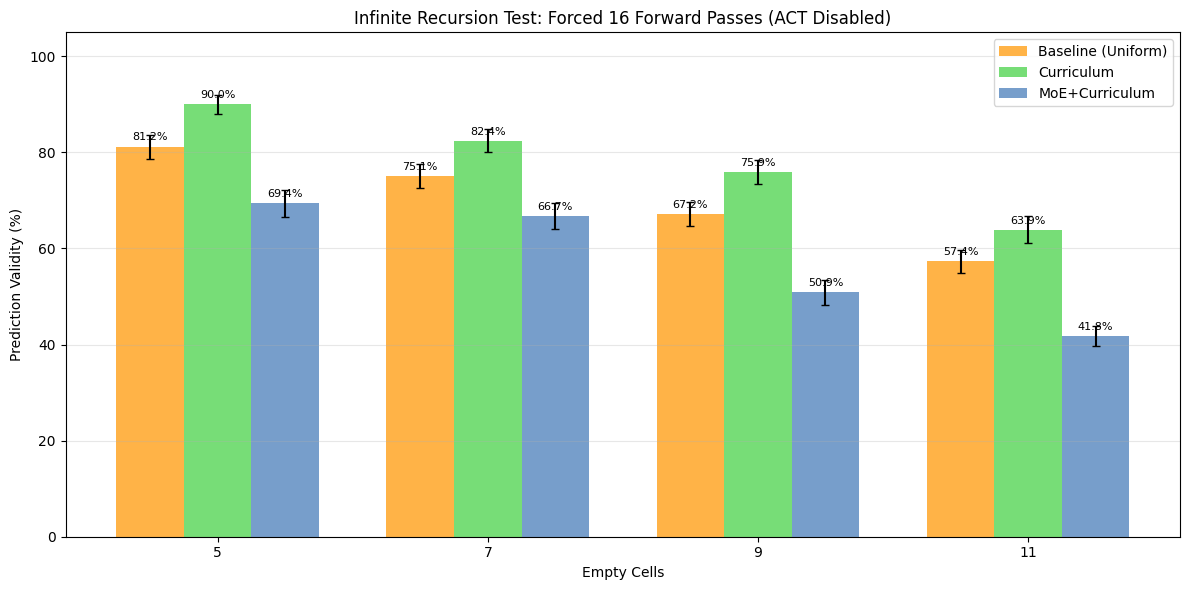


SUMMARY: Infinite Recursion (16 steps)
  Baseline (Uniform):  70.2% validity, 34% solve rate
  Curriculum:          78.1% validity, 50% solve rate
  MoE+Curriculum:      57.2% validity, 20% solve rate

  Accuracy Comparison (Forced 16 Steps):
    Curriculum vs Baseline: +7.8%
    MoE vs Curriculum:      -20.9%
    MoE vs Baseline:        -13.0%

INTERPRETATION:
  - If scores are similar to ACT-enabled: models are robust to extra computation
  - If scores DROP with more steps: models may "overthink" (reasoning collapse)
  - If scores INCREASE: ACT is halting too early, more computation helps


In [25]:
# ============================================================
# INFINITE RECURSION TEST: Force Maximum Steps (Disable ACT)
# ============================================================
# Compare all models when ACT is disabled
# All models run maximum 16 steps - tests whether more computation helps or hurts

import torch
import numpy as np
import matplotlib.pyplot as plt
from models.recursive_reasoning.trm import TinyRecursiveReasoningModel_ACTV1
from models.rule_rl.train import generate_puzzle
from tests.evaluation import count_prediction_validity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Force maximum steps (disable ACT halting)
FORCED_STEPS = 16  # Force all models to run exactly 16 forward passes
NUM_SAMPLES = 100  # Samples per difficulty

print(f'\n{"="*80}')
print(f'INFINITE RECURSION TEST: Force {FORCED_STEPS} forward passes (ACT disabled)')
print(f'{"="*80}')

# Base config
config = {
    'batch_size': 1, 'seq_len': 16, 'vocab_size': 6,
    'hidden_size': HIDDEN_SIZE, 'num_heads': NUM_HEADS, 'expansion': 4,
    'H_cycles': H_CYCLES, 'L_cycles': L_CYCLES, 'H_layers': 0, 'L_layers': L_LAYERS,
    'pos_encodings': 'rope', 'rms_norm_eps': 1e-5, 'rope_theta': 10000.0,
    'puzzle_emb_ndim': 0, 'puzzle_emb_len': 0, 'num_puzzle_identifiers': 1,
    'halt_max_steps': 16, 'halt_exploration_prob': 0.0, 'forward_dtype': 'bfloat16',
    'detach_early_cycles': False,
}

# MoE config
MOE_NUM_EXPERTS = 16
MOE_TOP_K = 4
MOE_SHARED = True

moe_config = {
    **config,
    'use_moe': True,
    'num_experts': MOE_NUM_EXPERTS,
    'top_k': MOE_TOP_K,
    'shared_expert': MOE_SHARED,
}

# Load models
print('\nLoading models...')

def load_model_state(ckpt):
    """Handle different checkpoint formats."""
    if 'model' in ckpt:
        return ckpt['model']
    elif 'model_state_dict' in ckpt:
        return ckpt['model_state_dict']
    else:
        raise KeyError(f"Checkpoint has no 'model' or 'model_state_dict'. Keys: {list(ckpt.keys())}")

baseline_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
baseline_ckpt = torch.load('checkpoints/uniform_baseline/uniform_baseline_model.pt', map_location=device)
baseline_model.load_state_dict(load_model_state(baseline_ckpt))
baseline_model.eval()
print('  ✓ Baseline (Uniform) loaded')

curriculum_model = TinyRecursiveReasoningModel_ACTV1(config).to(device)
curr_ckpt = torch.load('checkpoints/curriculum_supervised/curriculum_sup_model.pt', map_location=device)
curriculum_model.load_state_dict(load_model_state(curr_ckpt))
curriculum_model.eval()
print('  ✓ Curriculum loaded')

moe_model = TinyRecursiveReasoningModel_ACTV1(moe_config).to(device)
moe_ckpt = torch.load('checkpoints/moe_supervised/moe_curriculum_model.pt', map_location=device)
moe_model.load_state_dict(load_model_state(moe_ckpt))
moe_model.eval()
print('  ✓ MoE+Curriculum loaded')

def test_forced_steps(model, num_empty, num_samples, forced_steps):
    """Test model with forced number of forward passes (ACT disabled)."""
    valid_counts = []
    total_counts = []
    
    for _ in range(num_samples):
        puzzle, solution = generate_puzzle(4, num_empty)
        puzzle_t = puzzle.unsqueeze(0).to(device)
        
        batch = {
            'inputs': puzzle_t,
            'puzzle_identifiers': torch.zeros(1, dtype=torch.long, device=device)
        }
        
        carry = model.initial_carry(batch)
        carry.inner_carry.z_H = carry.inner_carry.z_H.to(device)
        carry.inner_carry.z_L = carry.inner_carry.z_L.to(device)
        carry.halted = carry.halted.to(device)
        carry.steps = carry.steps.to(device)
        
        with torch.no_grad():
            # Force exactly `forced_steps` forward passes (ignore ACT halting)
            for _ in range(forced_steps):
                carry, outputs = model(carry, batch)
        
        # Evaluate predictions (move to CPU for evaluation)
        preds = outputs['logits'].argmax(dim=-1)[0].cpu()
        mask = (puzzle == 1)  # Empty cells (puzzle is already on CPU)
        
        # Complete puzzle and check validity
        completed = puzzle.clone()
        completed[mask] = preds[mask]
        completed_digits = completed - 1  # Token space to digit space
        
        valid, total = count_prediction_validity(completed_digits, mask, size=4)
        valid_counts.append(valid)
        total_counts.append(total)
    
    # Calculate statistics
    validity_rates = [v/t if t > 0 else 0 for v, t in zip(valid_counts, total_counts)]
    mean_validity = np.mean(validity_rates) * 100
    se_validity = np.std(validity_rates) / np.sqrt(len(validity_rates)) * 100
    
    return {
        'acc': mean_validity,
        'se': se_validity,
        'solve_rate': sum(v == t for v, t in zip(valid_counts, total_counts)) / len(valid_counts) * 100
    }

# Run comparison
print(f'\n{"="*100}')
print(f'FORCED {FORCED_STEPS} STEPS - Prediction Validity Rate')
print(f'(n={NUM_SAMPLES} puzzles per difficulty, ACT halting DISABLED)')
print(f'{"="*100}')
print()
print(f'{"Empty":<8} {"Baseline (Uniform)":<28} {"Curriculum":<28} {"MoE+Curriculum":<28}')
print('-'*100)

results = {'baseline': [], 'curriculum': [], 'moe': []}
results_se = {'baseline': [], 'curriculum': [], 'moe': []}
solve_rates = {'baseline': [], 'curriculum': [], 'moe': []}

for num_empty in [5, 7, 9, 11]:  # Interpolation difficulties
    r_base = test_forced_steps(baseline_model, num_empty, NUM_SAMPLES, FORCED_STEPS)
    r_curr = test_forced_steps(curriculum_model, num_empty, NUM_SAMPLES, FORCED_STEPS)
    r_moe = test_forced_steps(moe_model, num_empty, NUM_SAMPLES, FORCED_STEPS)
    
    results['baseline'].append(r_base['acc'])
    results['curriculum'].append(r_curr['acc'])
    results['moe'].append(r_moe['acc'])
    results_se['baseline'].append(r_base['se'])
    results_se['curriculum'].append(r_curr['se'])
    results_se['moe'].append(r_moe['se'])
    solve_rates['baseline'].append(r_base['solve_rate'])
    solve_rates['curriculum'].append(r_curr['solve_rate'])
    solve_rates['moe'].append(r_moe['solve_rate'])
    
    print(f'{num_empty:<8} {r_base["acc"]:>5.1f}% ±{r_base["se"]:.1f}  ({r_base["solve_rate"]:>5.1f}% solved)   '
          f'{r_curr["acc"]:>5.1f}% ±{r_curr["se"]:.1f}  ({r_curr["solve_rate"]:>5.1f}% solved)   '
          f'{r_moe["acc"]:>5.1f}% ±{r_moe["se"]:.1f}  ({r_moe["solve_rate"]:>5.1f}% solved)')

print('-'*100)
avg_base = np.mean(results['baseline'])
avg_curr = np.mean(results['curriculum'])
avg_moe = np.mean(results['moe'])
avg_solve_base = np.mean(solve_rates['baseline'])
avg_solve_curr = np.mean(solve_rates['curriculum'])
avg_solve_moe = np.mean(solve_rates['moe'])

print(f'{"AVG":<8} {avg_base:>5.1f}% ({avg_solve_base:>4.0f}% solved)            '
      f'{avg_curr:>5.1f}% ({avg_solve_curr:>4.0f}% solved)            '
      f'{avg_moe:>5.1f}% ({avg_solve_moe:>4.0f}% solved)')

# Compare with ACT results (from previous cell)
print()
print('='*100)
print('COMPARISON: ACT-Enabled vs Forced 16 Steps')
print('='*100)
print()
print('NOTE: If ACT-enabled scores are HIGHER, the model learned when to stop.')
print('      If Forced-16 scores are HIGHER, more computation helps (ACT halted too early).')
print()
print('To compare, run the previous cell (Cell 11) and compare the results.')
print()

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

difficulties = [5, 7, 9, 11]
x = np.arange(len(difficulties))
width = 0.25

bars1 = ax.bar(x - width, results['baseline'], width, yerr=results_se['baseline'], 
               label='Baseline (Uniform)', color='#FFB347', capsize=3)
bars2 = ax.bar(x, results['curriculum'], width, yerr=results_se['curriculum'],
               label='Curriculum', color='#77DD77', capsize=3)
bars3 = ax.bar(x + width, results['moe'], width, yerr=results_se['moe'],
               label='MoE+Curriculum', color='#779ECB', capsize=3)

ax.set_xlabel('Empty Cells')
ax.set_ylabel('Prediction Validity (%)')
ax.set_title(f'Infinite Recursion Test: Forced {FORCED_STEPS} Forward Passes (ACT Disabled)')
ax.set_xticks(x)
ax.set_xticklabels(difficulties)
ax.legend()
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('tests/infinite_recursion_test.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f'\n✓ Saved: tests/infinite_recursion_test.png')
plt.show()

# Summary
print()
print('='*100)
print('SUMMARY: Infinite Recursion ({} steps)'.format(FORCED_STEPS))
print('='*100)
print(f'  Baseline (Uniform):  {avg_base:.1f}% validity, {avg_solve_base:.0f}% solve rate')
print(f'  Curriculum:          {avg_curr:.1f}% validity, {avg_solve_curr:.0f}% solve rate')
print(f'  MoE+Curriculum:      {avg_moe:.1f}% validity, {avg_solve_moe:.0f}% solve rate')
print()
print('  Accuracy Comparison (Forced 16 Steps):')
print(f'    Curriculum vs Baseline: {avg_curr - avg_base:+.1f}%')
print(f'    MoE vs Curriculum:      {avg_moe - avg_curr:+.1f}%')
print(f'    MoE vs Baseline:        {avg_moe - avg_base:+.1f}%')
print()
print('INTERPRETATION:')
print('  - If scores are similar to ACT-enabled: models are robust to extra computation')
print('  - If scores DROP with more steps: models may "overthink" (reasoning collapse)')
print('  - If scores INCREASE: ACT is halting too early, more computation helps')


In [ ]:
# Save test results to JSON
import json
import os
from datetime import datetime

os.makedirs('tests', exist_ok=True)

test_results = {
    'timestamp': datetime.now().isoformat(),
    'test_type': 'interpolation',
    'difficulties': [5, 7, 9, 11],
    'num_samples': NUM_SAMPLES,
    'H_CYCLES': H_CYCLES,
    'results': {
        'baseline': {
            'prediction_validity': results['baseline'],
            'standard_error': results_se['baseline'],
            'solve_rate': solve_rates['baseline'],
            'avg_validity': avg_base,
            'avg_solve': avg_solve_base,
        },
        'curriculum': {
            'prediction_validity': results['curriculum'],
            'standard_error': results_se['curriculum'],
            'solve_rate': solve_rates['curriculum'],
            'avg_validity': avg_curr,
            'avg_solve': avg_solve_curr,
        },
        'moe': {
            'prediction_validity': results['moe'],
            'standard_error': results_se['moe'],
            'solve_rate': solve_rates['moe'],
            'avg_validity': avg_moe,
            'avg_solve': avg_solve_moe,
        },
    },
    'model_params': {
        'baseline': sum(p.numel() for p in baseline_model.parameters()),
        'curriculum': sum(p.numel() for p in sup_model.parameters()),
        'moe': sum(p.numel() for p in moe_model.parameters()),
    }
}

log_path = 'tests/interpolation_test_results.json'
with open(log_path, 'w') as f:
    json.dump(test_results, f, indent=2)
print(f'✓ Saved results: {log_path}')

✓ Saved results: tests/interpolation_test_results.json
